# Fitting potential energy surfaces using neural networks

In this notebook we will go through the workflow of fitting a potential energy surface with a neural network. 

As you saw this morning in the digit classification example, the "pipeline" refers to the set of steps that need to be carried out to go from raw data to a fitted model. Here we will follow a similar structure.

## 1. The raw data

In this exercise, the 'raw data' consists of a data set where each sample (row) is a different configuration of a methane and cyanide radical. To each configuration corresponds an energy. The energies are relative (one configuration has been chosen to be the zero of energy). 

Therefore, the first step is to import the raw data. One numpy array will contain the 'X' part of the data (the configuration of the molecule) and another will contain the 'y' part (the energy).

In [1]:
import sys
sys.path.append('.')
import pre_processing as pp
import numpy as np

X, y = pp.loadData('data.csv')

## 2. Pre-processing

The raw data has to be transformed from Cartesian coordinates to a molecular descriptor. This has to be suitable as a neural network input. Cartesian coordinates are not suitable because they are not *rotationally and translationally invariant*. Translational invariance simply means that if you shift a molecule in space then the coordinates should **not** change. Similarly, if you rotate a whole molecule around, its Cartesian coordinates should **not** change.

There are a variety of descriptors to choose from. Many of them are explained [here](http://aip.scitation.org/doi/full/10.1063/1.4966192). In this workshop, we will use the unsorted/unrandomised Coulomb matrix. The way the Coulomb matrix is constructed is explained [here](http://pubs.acs.org/doi/abs/10.1021/ct400195d). 

This version of the Coulomb matrix is not what you would use for a serious application of neural networks, because it does not satisfy permutational invariance. However, it is a simple descriptor and it is good enough for the purpose of this tutorial. 

Each line of `X_cm` is a 'sample', i.e. a configuration of the system under study. There are in total 17751  configurations. The system has 7 atoms and the Coulomb matrix is a diagonal matrix of shape 7 by 7. But since it is diagonal, only the upper triangular part is needed. Hence the shape `(17751, 28)`.

In [2]:
# Generating the Coulomb matrix
descriptor = pp.CoulombMatrix(matrixX=X)
X_cm = descriptor.generateTriangCM()

print('X_cm has shape {}.'.format(str(X_cm.shape)))
print('y has shape {}.'.format(str(y.shape)))

X_cm has shape (17751, 28).
y has shape (17751,).


## 3. Scaling

Usually, after having extracted the relevant information from the data, one can normalise it - i.e. make every column (also called 'feature') have a  standard deviation of 1 and mean of 0. This can be useful, because it means that the weights of the neural network can be in a similar range (which can help for the regularisation).

However, if the ratio of the features contains information, then scaling looses it. The diagonal elements of the Coulomb  matrix are always the same because they show the chemical identity of an atom. If this feature was scaled, all atoms would have a zero where their nuclear charge would have been, and therefore the chemical identity information would be lost.

Consequently, no scaling is done on the Coulomb matrix.

## 3. Hyper-parameters

In the neural network, there are many parameters that have to be chosen in order to obtain optimal performance. For example, there is the structure of the network (how many hidden layers, how many neurons in each layer), the regularisation parameter, the learning rate and the batch size in the mini-batch gradient descent... These are called 'hyper-parameters'. 

The hyper-parameter have to be optimised. This is usually done by trying different combinations of them and scoring the model. The hyper-parameters that give the best model are then kept. There are various techniques to do this, like manually choosing the different combinations of hyper parameters, grid search, random search, Gaussian processes...

For the purpose of this tutorial, we will just do a grid search. For actual applications, Gaussian processes are generally used.

In [3]:
import sklearn.model_selection as modsel

# Splitting the data into train set and test set
x_train, x_test, y_train, y_test = modsel.train_test_split(X_cm, y, test_size=0.2, random_state=0)

In [4]:
from sklearn import neural_network as nn

# Creating the neural network
neural_net = nn.MLPRegressor(max_iter=100000, random_state=0)

In [5]:
# Creating a dictionary with the hyper-parameter to optimise
hyper_param = {}

# Structure of the neural net
HLS =[(40,20,10), (50, 30, 15), (60, 40, 20)]
hyper_param.update({'neural_net__hidden_layer_sizes':HLS})

# Learning rate
LRI = [0.001, 0.005, 0.01]
hyper_param.update({'neural_net__learning_rate_init':LRI})

# Regularisation parameter
ALPHA = np.logspace(-3,-1,3)
hyper_param.update({'neural_net__alpha':ALPHA})

In Scikit learn, in order to do a grid search, one has to create a 'pipeline'. This is a collection of all the operations required to go from raw data to having a fitted model. In our example, the only step needed in the pipeline is the neural network regression, as no scaling was done on the data.

The hyper-parameters that we will optimise here are the learning rate, the regularisation parameter and the structure of the neural network. In scikit learn, the notation `(4, 3, 2)` means that the neural network has 3 hidden layers, the first one has 4 neurons, the second has 3 and the third has 2. 

In [6]:
from sklearn.pipeline import Pipeline

# Generating the pipeline
pipe = Pipeline([('neural_net', neural_net)])

# Doing the gridsearch - i.e. trying all the combinations of parameters
grid_search = modsel.GridSearchCV(estimator=pipe, param_grid=hyper_param)
grid_search.fit(x_train, y_train)

print('Best accuracy: {:4.2f}'.format(grid_search.best_score_))
print('Best params: \n{}'.format(grid_search.best_params_))

Best accuracy: 0.51
Best params: 
{'neural_net__alpha': 0.10000000000000001, 'neural_net__learning_rate_init': 0.005, 'neural_net__hidden_layer_sizes': (60, 40, 20)}


In [7]:
# Updating the model to set the best hyper-parameters 
best_params = {}

best_params.update({'neural_net__hidden_layer_sizes':grid_search.best_params_['neural_net__hidden_layer_sizes']})
best_params.update({'neural_net__learning_rate_init': grid_search.best_params_['neural_net__learning_rate_init']})
best_params.update({'neural_net__alpha': grid_search.best_params_['neural_net__alpha']})

# Set best parameters
pipe.set_params(**best_params)

# Refit model with best hyper-parameters, ready for prediction
pipe.fit(x_train, y_train)

Pipeline(steps=[('neural_net', MLPRegressor(activation='relu', alpha=0.10000000000000001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(60, 40, 20), learning_rate='constant',
       learning_rate_init=0.005, max_iter=100000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False))])

## 4. Evaluating the model on test data

Now that the neural network has been trained on the training data with an optimised set of hyper-parameters, it is time to use it to do some predictions. A nice way of visualising the quality of the fit is to do a correlation plot. This involves plotting the prediction vs the original values. More quantitative ways of judging how good the model is include root mean square errors, mean absolute errors, largest positive/negative outliers, etc.

In [8]:
# Predictions
y_pred = pipe.predict(x_test)

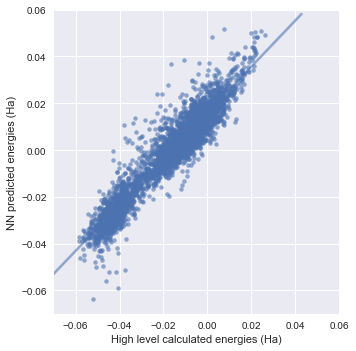

In [12]:
# Correlation plot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame()
df['High level calculated energies (Ha)'] = y_test
df['NN predicted energies (Ha)'] = y_pred
lm = sns.lmplot('High level calculated energies (Ha)', 'NN predicted energies (Ha)', data=df,
                scatter_kws={"s": 20, "alpha": 0.6}, line_kws={"alpha": 0.5})
lm.set(ylim=[-0.07,0.06])
lm.set(xlim=[-0.07,0.06])

plt.show()

# Exercises

As you can see, the correlation plot shows that the results are not that good. You could try the following things:

1. Find a better combination of the values of the learning rate, the regularisation parameter and the structure of the neural network.
2. Try modifying which hyper-parameters are optimised. For example, you could try changing the batch-size for the mini-batch stochastic optimiser.

There are also other things that can be changed. For example:

3. Currently we are using the default activation function 'relu'. You could try the `logistic`, `identity` and `tanh` activation functions and see how this modifies the performance. You can find information about what these are [here](https://theclevermachine.wordpress.com/tag/tanh-function/).
4. When optimising the hyper-parameters, we used a grid search. You could try to use `RandomisedSearchCV` which is the scikit-learn implementation of random search. You could also try one of the non-brute force ways. More information can be found [here](http://scikit-learn.org/stable/modules/grid_search.html).
5. In this example, when the model was trained for the hyper-parameter optimisation we used *all* the training data. A good thing to do is to train the model only on *a subset* of the data and the remaining data is used to test it. This process is referred to as "cross-validation". You can read about the different versions of cross-validation [here](https://www.cs.cmu.edu/~schneide/tut5/node42.html). You could then try to use `KFold` from Scikit learn and see if things change.